# Ensemble models

## Get the data

In [61]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('../data/data_preprocessed.csv')
data.head()

,Hour,Wind direction (gr),Wind speed (m/s),Wind gust max (m/s),Date,Relative humidity max,Relative humidity min,Temperature max (K),Relative humidity,Atmospheric pressure at station level (Pa),Precipitation (m)
0,12,0.809017,1.8,3.8,2000-01-01 12:00:00,0.69,0.60,293.85,0.61,88820.0,0.0
1,13,0.965926,2.7,4.7,2000-01-01 13:00:00,0.62,0.55,295.65,0.55,88840.0,0.0
2,14,0.891007,2.0,4.9,2000-01-01 14:00:00,0.56,0.50,297.45,0.51,88810.0,0.0
3,15,0.848048,2.5,5.8,2000-01-01 15:00:00,0.52,0.44,298.15,0.44,88740.0,0.0
4,16,0.224951,2.4,5.8,2000-01-01 16:00:00,0.50,0.43,298.65,0.46,88650.0,0.0


In [62]:
#implement a ensemble model to predict the wind speed using voting classifier and random forest, gradient boosting and knn
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


input = [col for col in data.columns if col not in {'Wind speed (m/s)', 'Date'}]

X, y = data[input], data['Wind speed (m/s)']
# Splitting the data into training and testing data but use the fisrt 80% of the data for training and the rest for testing
X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

In [63]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from skopt.space import Real, Categorical, Integer

n_col = X_train.shape[1]

dict_models = [
    {
        'name_model': 'Gradient_Boosting',
        'model': GradientBoostingRegressor(random_state=42),
        'scalers': {
            'scaler': Categorical([None]),
        },
        'grid': {
            'model__n_estimators': Integer(10, 300),
            'model__max_depth': Integer(1, n_col),
            'model__learning_rate': Real(0.01, 1),
        },
    },

    {
        'name_model': 'Random_Forest',
        'model': RandomForestRegressor(random_state=42),
        'scalers': {
            'scaler': Categorical([None]),
        },
        'grid': {
            'model__n_estimators': Integer(10, 300),
            'model__max_depth': Integer(1, n_col),
        },
    },

    {
        'name_model': 'Decision_Tree',
        'model': DecisionTreeRegressor(random_state=42),
        'scalers': {
            'scaler': Categorical([None]),
        },
        'grid': {
            'model__max_depth': Integer(1, n_col),
        },
        
    },

    {
        'name_model': 'Linear_Regression',
        'model': LinearRegression(),
        'scalers': {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()]),
        },
        'grid': {},
    },

    {
        'name_model': 'Ridge',
        'model': Ridge(),
        'scalers': {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()]),
        },
        'grid': {
            'model__alpha': Real(0.0001, 10000),
        },
    },

    {
        'name_model': 'KNN',
        'model': KNeighborsRegressor(),
        'scalers': {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()])
        },
        'grid': {
            'model__n_neighbors': Integer(1, 20)
        },
    },
    {
        'name_model': 'Lasso',
        'model': Lasso(),
        'scalers': {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()])
        },
        'grid': {
            'model__alpha': Real(0.0001, 10000),
        },
    },
]

In [64]:
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from time import time
from utils import model_evaluation_lr
import os
import pickle

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "CPU time", "RMSE", "R2"])
models = {}
nb_res = 0

for i, dict_model in enumerate(dict_models):
    model_name = dict_model['name_model']
    path_model = f"../pickle/models/{model_name}.pkl"
    path_time = f"../pickle/cpu_time/{model_name}_time.pkl"
    if not os.path.exists(path_model) or not os.path.exists(path_time):
        print(f'Training {model_name}...')

        model = dict_model['model']

        steps = [
            ('scaler', None),
            ('model', model),
        ]

        pipeline = Pipeline(steps)

        param_grid = {
            **dict_model['scalers'],
            **dict_model['grid']
        }

        model = BayesSearchCV(pipeline, search_spaces=param_grid, cv=5, n_jobs=-1, scoring='r2', n_iter=20, random_state=42)

        start_time = time()
        model.fit(X_train, y_train)
        end_time = time()
        duration = round(end_time - start_time)
        print(f"CPU Time: {duration}s")

        with open(path_model, 'wb') as f:
            pickle.dump(model, f)

        with open(path_time, 'wb') as f:
            pickle.dump(duration, f)
    
    else:
        with open(path_model, 'rb') as f:
            model = pickle.load(f)

        with open(path_time, 'rb') as f:
            duration = pickle.load(f)

    print(f"Best params {model_name}: \n{model.best_params_}")

    y_pred = model.predict(X_test)
    eval = model_evaluation_lr(y_test, y_pred)
    
    models[model_name] = model

    results.loc[nb_res] = [model_name, duration, eval['rmse'], eval['r2']]
    nb_res += 1

    print()

Best params Gradient_Boosting: 
OrderedDict([('model__learning_rate', 0.013594004182195795), ('model__max_depth', 8), ('model__n_estimators', 225), ('scaler', None)])

Best params Random_Forest: 
OrderedDict([('model__max_depth', 9), ('model__n_estimators', 300), ('scaler', None)])

Best params Decision_Tree: 
OrderedDict([('model__max_depth', 8), ('scaler', None)])

Best params Linear_Regression: 
OrderedDict([('scaler', None)])

Best params Ridge: 
OrderedDict([('model__alpha', 0.0001), ('scaler', MinMaxScaler())])

Best params KNN: 
OrderedDict([('model__n_neighbors', 20), ('scaler', StandardScaler())])

Best params Lasso: 
OrderedDict([('model__alpha', 0.0001), ('scaler', None)])



In [65]:
# remove the part of the string model__ from the keys and remove scaler from the keys
best_params_rf = {key.replace('model__', ''): value for key, value in models['Random_Forest'].best_params_.items()}
best_params_rf.pop('scaler')
best_params_gb = {key.replace('model__', ''): value for key, value in models['Gradient_Boosting'].best_params_.items()}
best_params_gb.pop('scaler')
best_params_knn = {key.replace('model__', ''): value for key, value in models['KNN'].best_params_.items()}
best_params_knn.pop('scaler')

print(best_params_rf)

{'max_depth': 9, 'n_estimators': 300}


## Ensemble model: Voting vs Staking

To create an ensemble model there are different ways to do it, i will analyze two of them: voting vs stacking

### Voting

Voting is implemented by the article we chose to get information to improve our prediction in wind speed, let's implement it and analyze the results

In [66]:
# import grid search
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(**best_params_rf)
gb = GradientBoostingRegressor(**best_params_gb)
knn = KNeighborsRegressor(**best_params_knn)
vc = VotingRegressor(estimators=[('rf', rf), ('gb', gb), ('knn', knn)], weights=[1, 1, 1])

vc.fit(X_train, y_train)



VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=9,
                                                   n_estimators=300)),
                            ('gb',
                             GradientBoostingRegressor(learning_rate=0.013594004182195795,
                                                       max_depth=8,
                                                       n_estimators=225)),
                            ('knn', KNeighborsRegressor(n_neighbors=20))],
                weights=[1, 1, 1])

In [78]:
with open('../pickle/models/Voting.pkl', 'wb') as f:
    pickle.dump(vc, f)

In [67]:
# use rmse mape and r2 as metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

y_pred = vc.predict(X_test)

print('RMSE:', round(sqrt(mean_squared_error(y_test, y_pred)),3))
print('MAE:', round(mean_absolute_error(y_test, y_pred),3))
print('R2:', round(r2_score(y_test, y_pred),3))

RMSE: 0.587
MAE: 0.444
R2: 0.777


In [68]:
print(results.to_string(index=False))

            Model  CPU time  RMSE    R2
Gradient_Boosting       252 0.558 0.799
    Random_Forest       239 0.566 0.793
    Decision_Tree         6 0.583 0.780
Linear_Regression         5 0.600 0.767
            Ridge         5 0.600 0.767
              KNN        15 0.604 0.764
            Lasso         6 0.606 0.763


As we can see the new model didn't really helped us in achiving better scores, actually it got a bit worse in both r2 and RMSE, that could be due from the voting system we use that is not the best for this case.


## Stacking Model

In [75]:
# import stacking regressor and lienar regression
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

estimators = [
    ('rf', RandomForestRegressor(**best_params_rf)),
    ('gb', GradientBoostingRegressor(**best_params_gb)),
    ('knn', KNeighborsRegressor(**best_params_knn))
]

stack = StackingRegressor(estimators=estimators, final_estimator=Ridge())

stack.fit(X_train, y_train)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=9,
                                                     n_estimators=300)),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.013594004182195795,
                                                         max_depth=8,
                                                         n_estimators=225)),
                              ('knn', KNeighborsRegressor(n_neighbors=20))],
                  final_estimator=Ridge())

In [79]:
# save the model
with open('../pickle/models/Stacking.pkl', 'wb') as f:
    pickle.dump(stack, f)

In [76]:
y_pred = stack.predict(X_test)

print('RMSE:', round(sqrt(mean_squared_error(y_test, y_pred)),3))
print('MAE:', round(mean_absolute_error(y_test, y_pred),3))
print('R2:', round(r2_score(y_test, y_pred),3))

RMSE: 0.561
MAE: 0.418
R2: 0.797


In [77]:
print(results.to_string(index=False))

            Model  CPU time  RMSE    R2
Gradient_Boosting       252 0.558 0.799
    Random_Forest       239 0.566 0.793
    Decision_Tree         6 0.583 0.780
Linear_Regression         5 0.600 0.767
            Ridge         5 0.600 0.767
              KNN        15 0.604 0.764
            Lasso         6 0.606 0.763


Using stacking we got a worse score that could be due by a lot of factors, let's try with a non linear final estimator to see if we could get something better

In [72]:
stack_knn = StackingRegressor(estimators=estimators, final_estimator=KNeighborsRegressor())

stack_knn.fit(X_train, y_train)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=9,
                                                     n_estimators=300)),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.013594004182195795,
                                                         max_depth=8,
                                                         n_estimators=225)),
                              ('knn', KNeighborsRegressor(n_neighbors=20))],
                  final_estimator=KNeighborsRegressor())

In [80]:
# save the model
with open('../pickle/models/Stacking_Knn.pkl', 'wb') as f:
    pickle.dump(stack_knn, f)

In [73]:
y_pred = stack_knn.predict(X_test)

print('RMSE:', round(sqrt(mean_squared_error(y_test, y_pred)),3))
print('MAE:', round(mean_absolute_error(y_test, y_pred),3))
print('R2:', round(r2_score(y_test, y_pred),3))

RMSE: 0.612
MAE: 0.461
R2: 0.757


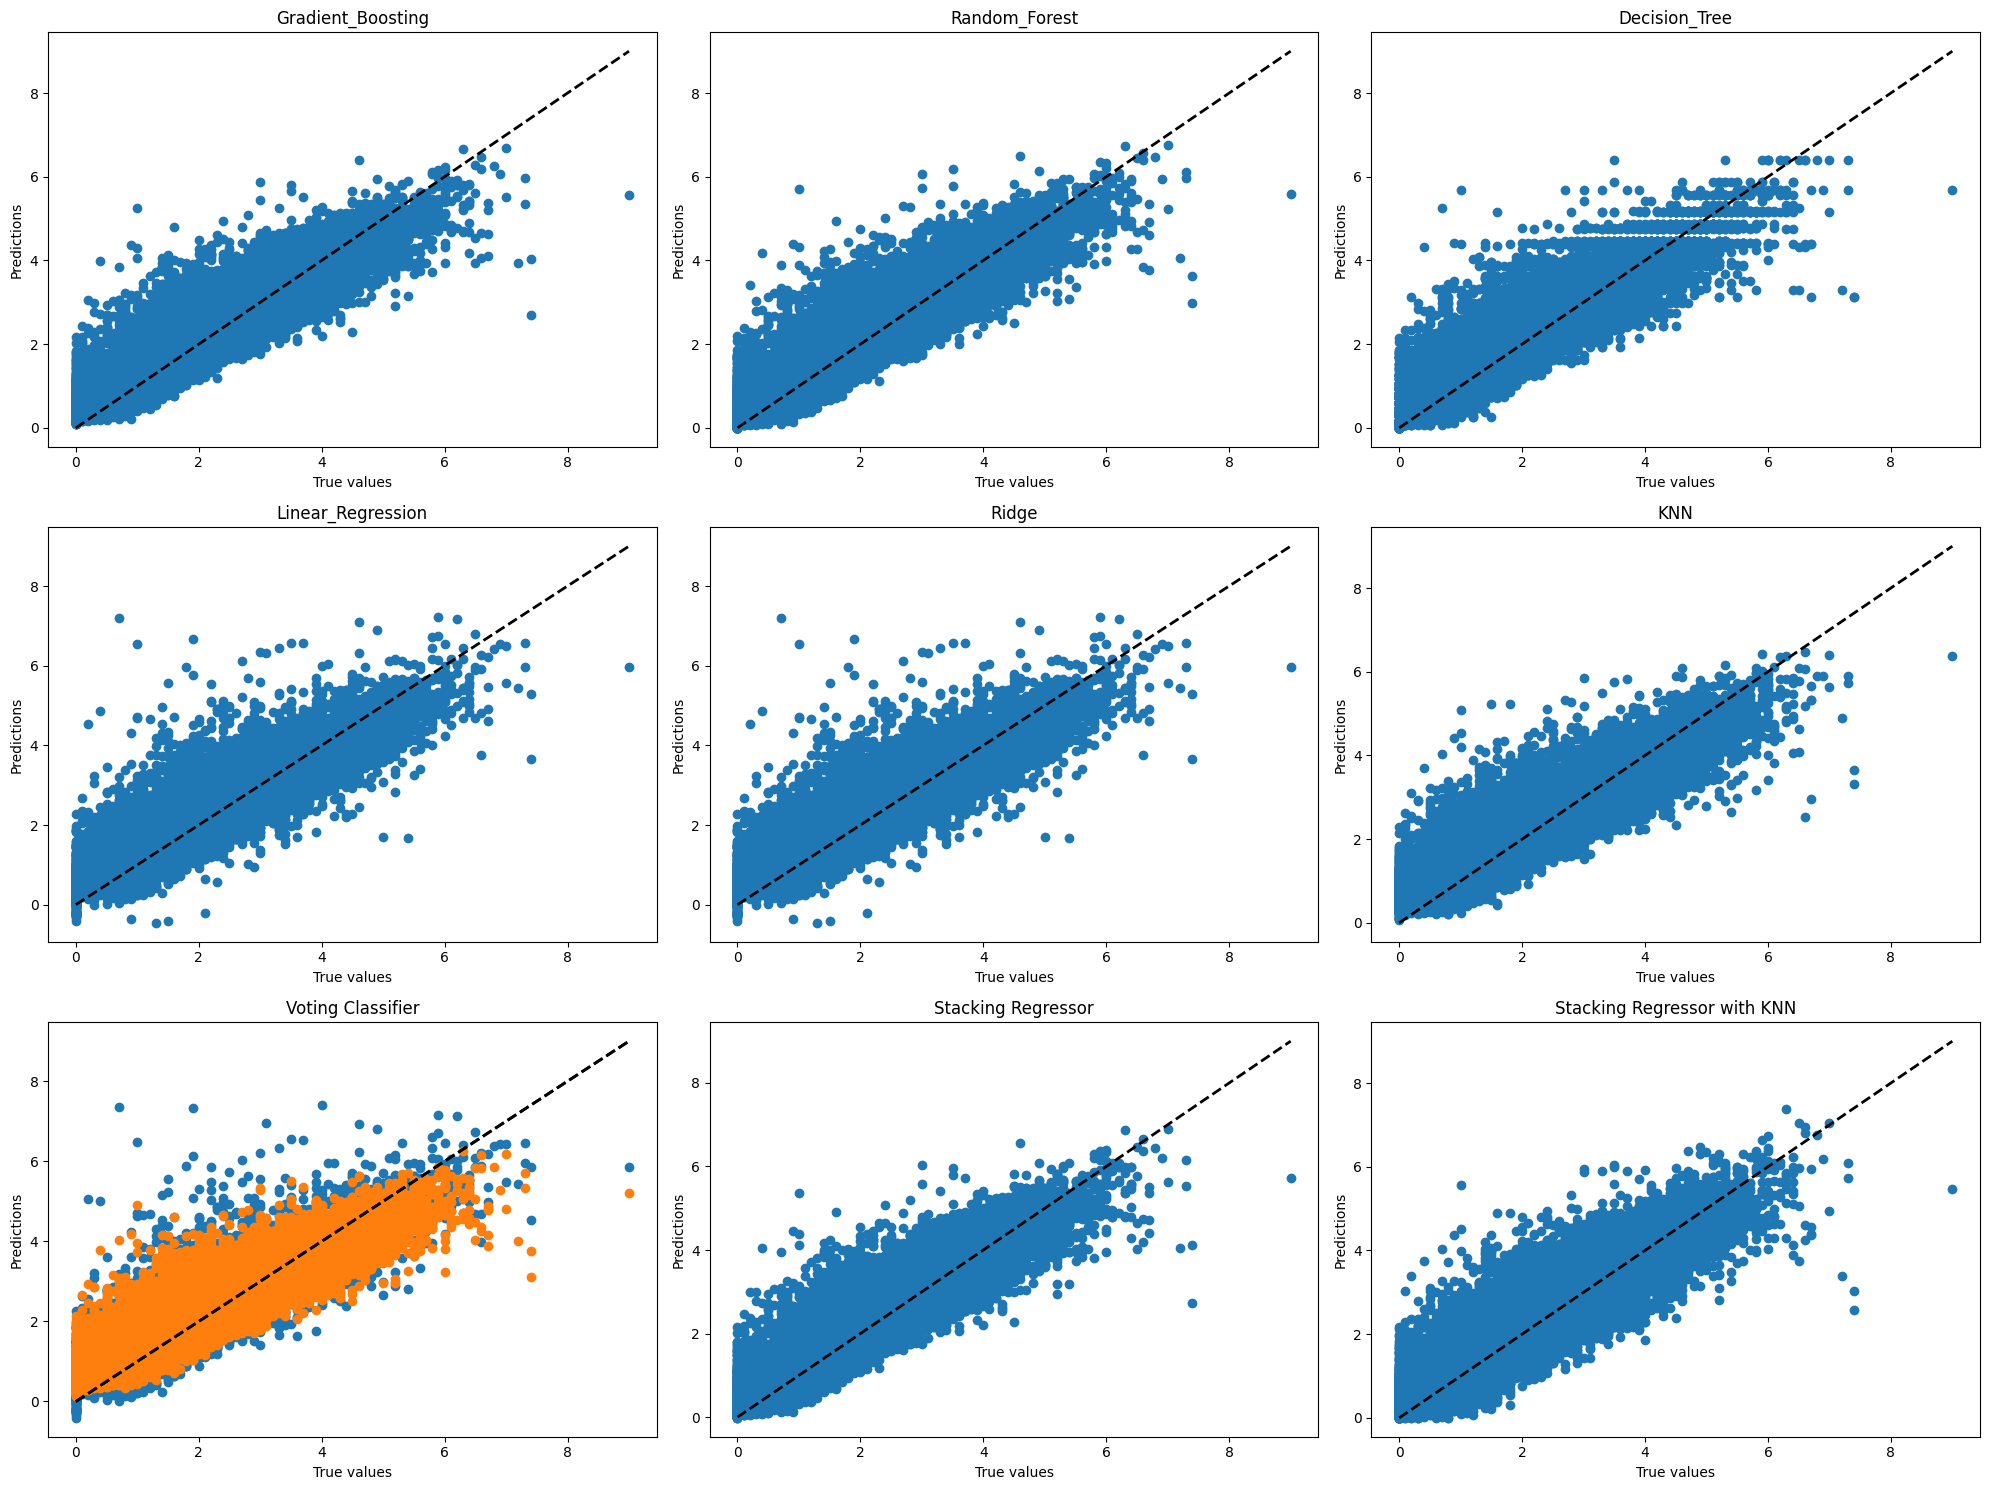

In [74]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()

for i, model_name in enumerate(models.keys()):
    model = models[model_name]
    y_pred = model.predict(X_test)

    axs[i].plot([0, y_test.max()], [0, y_test.max()], 'k--', lw=2)
    axs[i].scatter(y_test, y_pred)
    axs[i].set_xlabel('True values')
    axs[i].set_ylabel('Predictions')
    axs[i].set_title(model_name)

# add the ensemble models
y_pred = vc.predict(X_test)
axs[6].plot([0, y_test.max()], [0, y_test.max()], 'k--', lw=2)
axs[6].scatter(y_test, y_pred)
axs[6].set_xlabel('True values')
axs[6].set_ylabel('Predictions')
axs[6].set_title('Voting Classifier')

y_pred = stack.predict(X_test)
axs[7].plot([0, y_test.max()], [0, y_test.max()], 'k--', lw=2)
axs[7].scatter(y_test, y_pred)
axs[7].set_xlabel('True values')
axs[7].set_ylabel('Predictions')
axs[7].set_title('Stacking Regressor')

y_pred = stack_knn.predict(X_test)
axs[8].plot([0, y_test.max()], [0, y_test.max()], 'k--', lw=2)
axs[8].scatter(y_test, y_pred)
axs[8].set_xlabel('True values')
axs[8].set_ylabel('Predictions')
axs[8].set_title('Stacking Regressor with KNN')


plt.tight_layout()
plt.show()

As we can see the ensemble models don t really help us in this specific case, in fact we obtain worse results than the standard models, and the best one remains gradient boost.
the ensemble models would work much better when we have standard model that are much better than others in specific areas so that we would use the best model for every specific area so that we would obtain much a better result for the whole test set

## Conclusion

In this analysis, we evaluated various machine learning models, including standard models and ensemble methods, to determine their performance on our specific dataset. Contrary to the common expectation that ensemble models improve overall performance by combining the strengths of individual models, our results demonstrated otherwise. The ensemble models not only failed to enhance the predictive accuracy but also resulted in worse outcomes compared to the standard models.

Among all the models tested, Gradient Boosting emerged as the top performer, consistently delivering the best results. This finding highlights that, in our case, the complexity and diversity introduced by ensemble methods did not translate into performance gains.

The effectiveness of ensemble models is highly contingent on the diversity and individual strengths of the base models. They are particularly advantageous when there are significant variations in model performance across different areas of the dataset. In scenarios where certain models excel in specific aspects, ensemble methods can leverage these strengths to achieve superior overall performance. However, when the base models exhibit similar performance levels, as observed in our analysis, the benefits of ensemble techniques diminish.

Therefore, for our dataset and modeling objectives, Gradient Boosting stands out as the optimal choice. Future work could explore further hyperparameter tuning and possibly different feature engineering strategies to potentially unlock the benefits of ensemble methods.